# Εργαστήριο 2 : Εισαγωγή στη Pytorch
[Pytorch Tutorials](https://https://pytorch.org/tutorials/)

In [0]:
import torch

### **Βασικές γνώσεις**


Τι είναι ένα **Tensor**?
  - Ισοδύναμο με μια numpy array
  - Array n-διαστάσεων

Γιατί είναι χρήσιμο?
  - Μπορεί να καταγράφει τον υπολογιστικό γράφο και τις παραγώγους
  - Δυναμική δομή δεδομένων
  - Μπορεί να χρησιμοποιήσει GPU acceleration για γρήγορους υπολογισμούς
 

---



In [0]:

x = torch.tensor([5,3])
y = torch.tensor([2,1])

print(x*y)

tensor([10,  3])


In [0]:
x = torch.zeros([2,5])
print(x.shape)

torch.Size([2, 5])


In [0]:
y = torch.rand([2,5])

In [0]:
y = y.view([1,10])
print(y.shape)

torch.Size([1, 10])




---



### **Χρήση του Iris Dataset για ταξινόμηση**

In [0]:
# Import data
import urllib.request
iris_data_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
urllib.request.urlretrieve(iris_data_url, 'iris.data')

import pandas as pd
# Read data
data = pd.read_csv('iris.data', header=None)
data.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label']

print(data.head())

   sepal_length  sepal_width  petal_length  petal_width        label
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa


In [0]:
# Create two separate dataframes
df1 = data
df2 = data.iloc[:,4].copy()

In [0]:
# Transform categories to numerics

df1.loc[df1.label=='Iris-setosa', 'label'] = 0
df1.loc[df1.label=='Iris-versicolor', 'label'] = 1
df1.loc[df1.label=='Iris-virginica', 'label'] = 2

# Append numerical labels to dataframe

data = pd.concat([df1,df2], axis=1)
data.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label_num', 'label']
print(data)

     sepal_length  sepal_width  ...  label_num           label
0             5.1          3.5  ...          0     Iris-setosa
1             4.9          3.0  ...          0     Iris-setosa
2             4.7          3.2  ...          0     Iris-setosa
3             4.6          3.1  ...          0     Iris-setosa
4             5.0          3.6  ...          0     Iris-setosa
..            ...          ...  ...        ...             ...
145           6.7          3.0  ...          2  Iris-virginica
146           6.3          2.5  ...          2  Iris-virginica
147           6.5          3.0  ...          2  Iris-virginica
148           6.2          3.4  ...          2  Iris-virginica
149           5.9          3.0  ...          2  Iris-virginica

[150 rows x 6 columns]




---



### **Προετοιμασία του dataset**

In [0]:
# Perform train-test split
from sklearn.model_selection import train_test_split
X = data.values[:, 0:4]
labels = data.values[:, 4]
X_train, X_test, y_train, y_test = train_test_split(data[data.columns[0:4]].values,
                                                    data.label_num.values, 
                                                    test_size=0.3,
                                                    random_state=2020)


In [0]:
# Feature scaling 
# ...so that all of them can be uniformly evaluated
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
print(type(y_train))

<class 'numpy.ndarray'>


### **Δημιουργία ενός νευρωνικού δικτύου**

In [0]:
import torch.nn as nn

class Net(nn.Module):
    # Init function : defines nn architecture
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 3)
        self.softmax = nn.Softmax(dim=1)

    # Forward function : contains
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        X = self.fc3(X)
        X = self.softmax(X)
        return X

### **Εκπαίδευση του δικτύου**

In [0]:
# Set some hyperparameters
learning_rate = 0.01
epochs = 2000
batch_size = 10

In [0]:
from torch.utils.data import Dataset, DataLoader

# Create a dataset subclass
class CustomDataset(Dataset):
  def __init__(self, data, label_num):
    super().__init__()
    self.data = data
    self.label = label_num

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, index):
    d = {'data': torch.from_numpy(self.data[index]).type(torch.float32),
         'label': torch.Tensor([self.label[index]]).type(torch.int64)}
    return d
  
trainset = CustomDataset(X_train, y_train)
testset = CustomDataset(X_test, y_test)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [0]:
import torch.nn.functional as F
import torch.optim as optim

# Create an instance of our network
net = Net()

# Set the loss function
criterion = nn.CrossEntropyLoss()

# Set the optimization method
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

# Initialize losses & accuracies of train and test set
train_losses = list()
test_losses = list()
train_acc = list()
test_acc = list()

# Training loop
for epoch in range(epochs):

  # Initialization for "trainloader loop"
  total_loss = 0
  total = 0
  correct = 0
  

  ### Loop in trainset ###
  for batch in trainloader:
    optimizer.zero_grad()
    # Arrange data into batches
    X = batch['data']
    y = batch['label'].view(-1)
    # Make the prediction
    y_pred = net(X)
    # Calculate num of total y and correct predictions
    total += float(y.size()[0])
    correct += float((torch.argmax(y_pred, axis=1) == y).sum())
    # Calculate train loss
    loss = criterion(y_pred, y)
    # Do backpropagation
    loss.backward()
    # Perform one step of optimization method
    optimizer.step()
    # Append loss of each loss to total_loss
    total_loss += loss
  # Evaluate train loss & accuracy per epoch
  train_losses.append(total_loss/len(trainloader))
  train_acc.append(correct/total)

  # Initialization for "testloader loop"
  eval_loss = 0
  total = 0
  correct = 0 

  ### Loop in testset ###
  for batch in testloader:
    # Arrange data into batches
    X = batch['data']
    y = batch['label'].view(-1)
    # Make the prediction
    y_pred = net(X)
    # Calculate num of total y and correct predictions
    total += float(y.size()[0])
    correct += float((torch.argmax(y_pred, axis=1) == y).sum())
    # Calculate evaluation loss
    loss = criterion(y_pred, y)
    eval_loss += loss
  
  # Evaluate train loss & accuracy per epoch!
  test_losses.append(eval_loss/len(testloader))
  test_acc.append(correct/total)

  if epoch % 100 == 0:
    print(f'Epoch {epoch+1} completed. Train_loss:{total_loss/len(trainloader)}, Test_loss:{eval_loss/len(testloader)}, acc:{100*correct/total:02.2f}%')



---



## **Αξιολόγηση**

[Scikit-learn metrics](https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics)

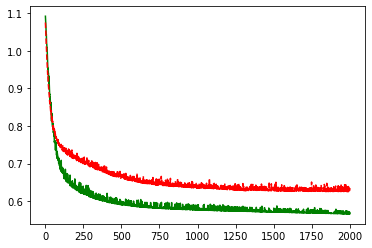

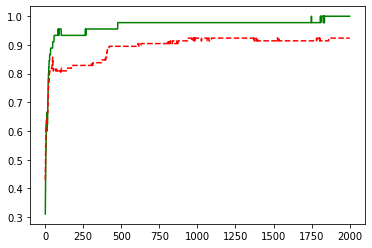

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, epochs+1), train_losses, 'g-')
plt.plot(range(1, epochs+1), test_losses, 'r--')

plt.figure()
plt.plot(range(1, epochs+1), train_acc, 'g-')
plt.plot(range(1, epochs+1), test_acc, 'r--')



---

